<a href="https://colab.research.google.com/github/chilam5/Data-Analytics-Class-Folder/blob/main/chilam_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

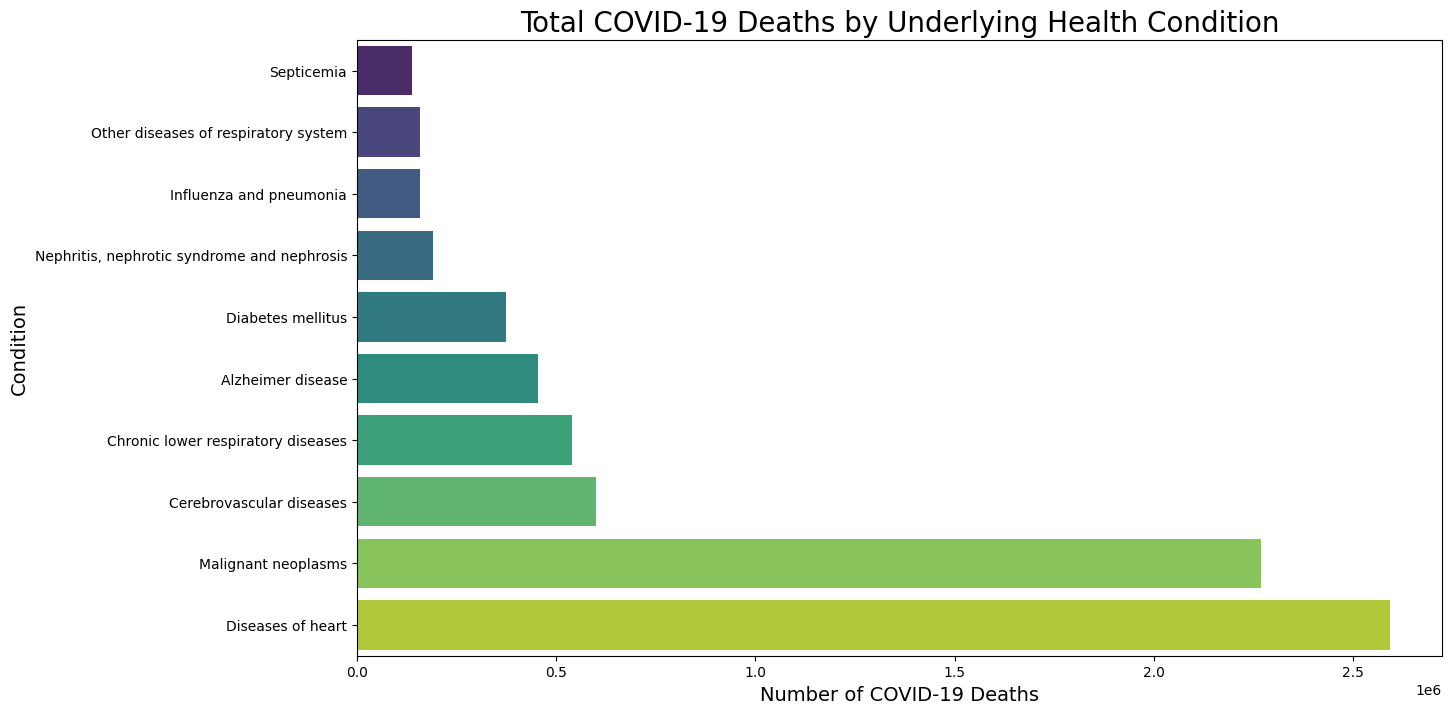

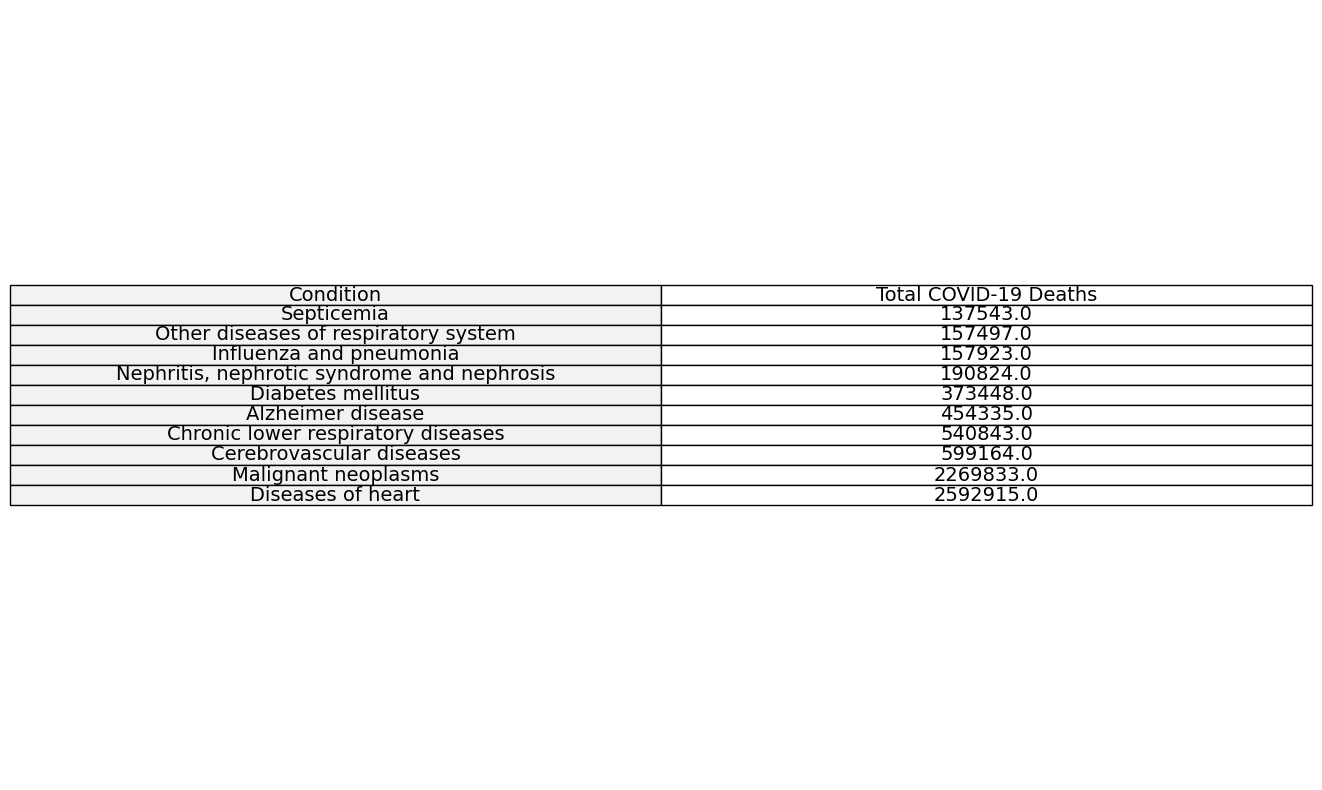

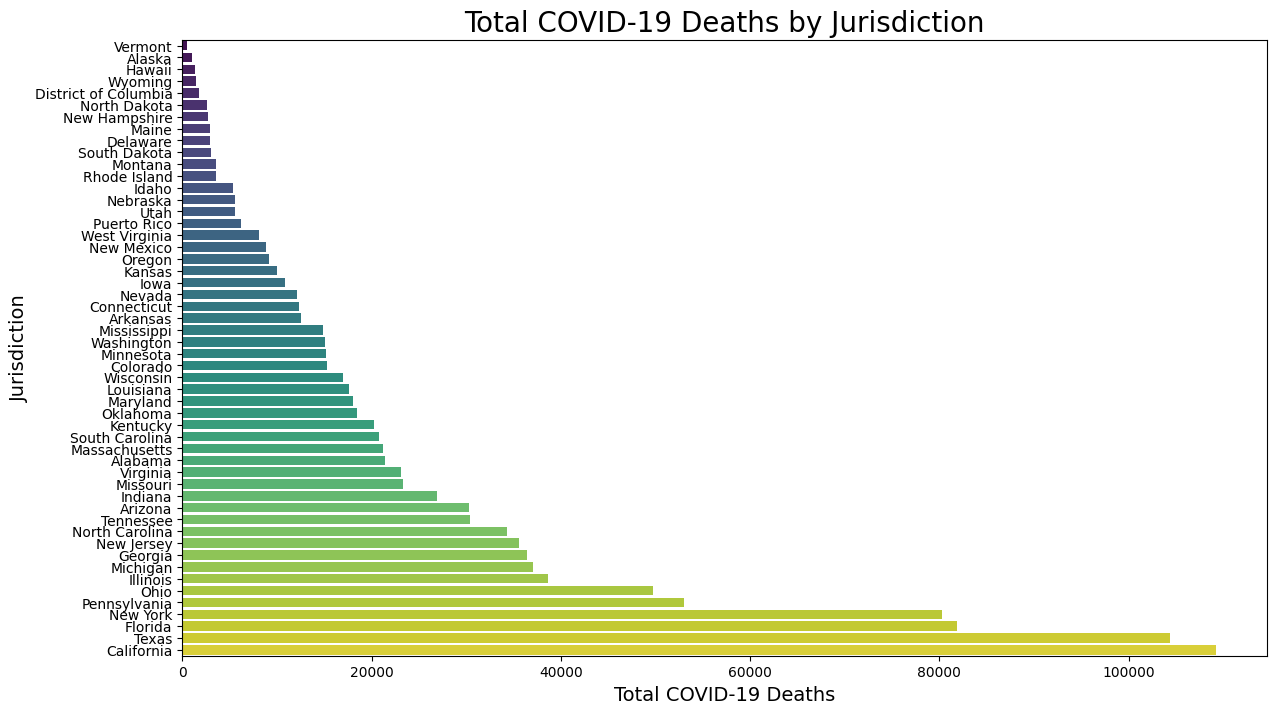

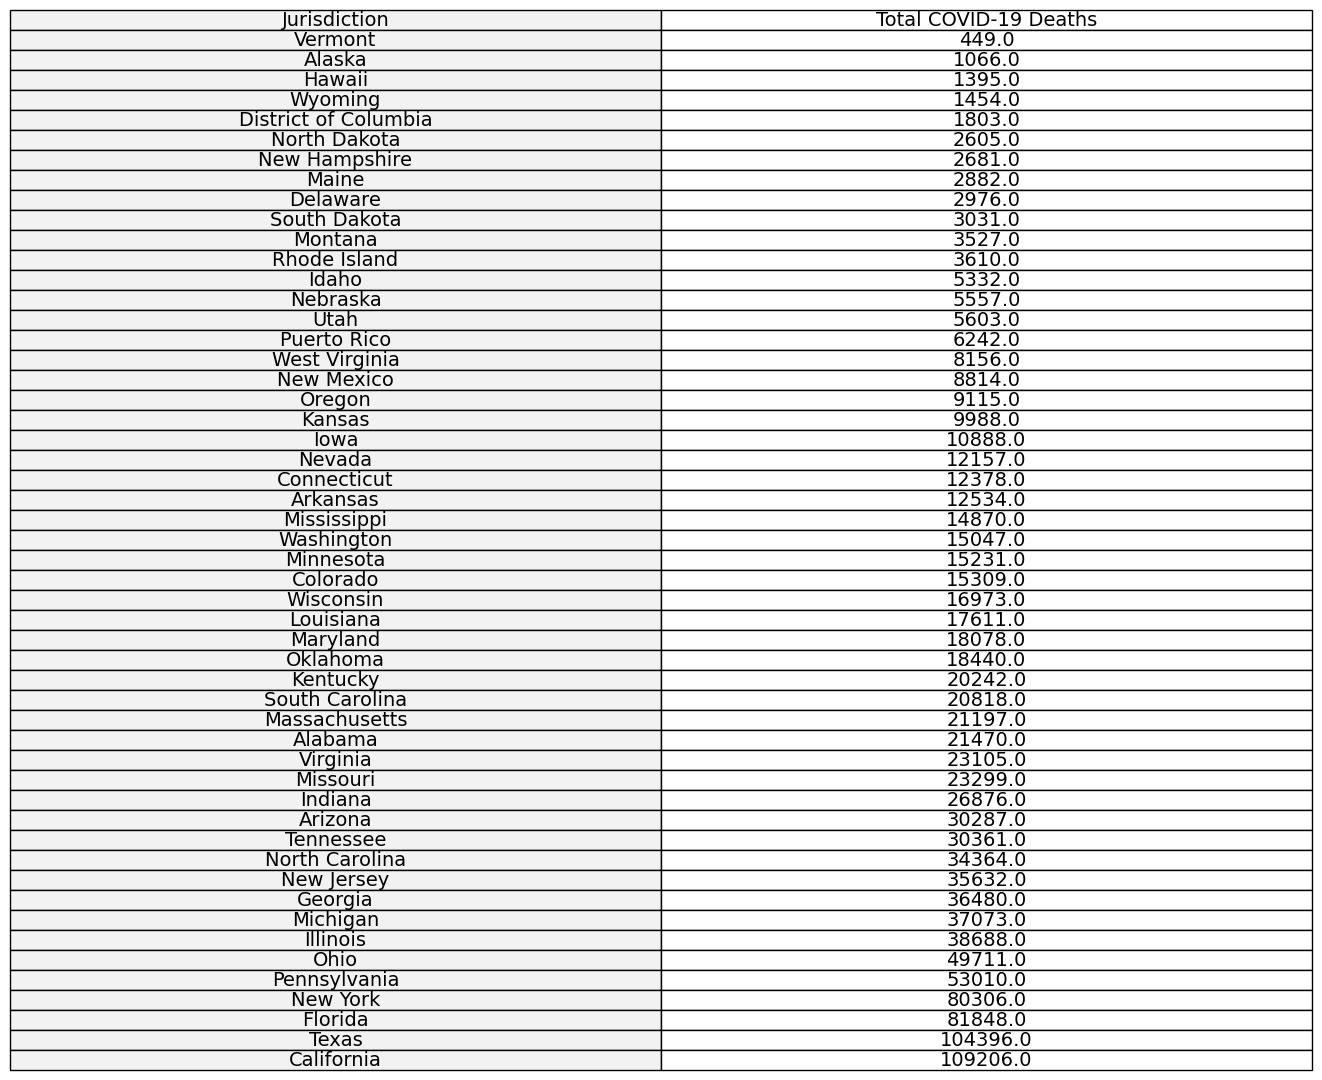

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = "https://data.cdc.gov/api/views/muzy-jte6/rows.csv?accessType=DOWNLOAD"
data = pd.read_csv(url)

# Data cleaning: fill missing values and convert data types
data_cleaned = data.copy()
data_cleaned['Week Ending Date'] = pd.to_datetime(data_cleaned['Week Ending Date'], errors='coerce')

# Columns to convert to numeric
numeric_columns = ['MMWR Year', 'MMWR Week', 'COVID-19 (U071, Multiple Cause of Death)', 'COVID-19 (U071, Underlying Cause of Death)']
condition_columns = ['Septicemia', 'Malignant neoplasms', 'Diabetes mellitus', 'Alzheimer disease', 'Influenza and pneumonia',
                     'Chronic lower respiratory diseases', 'Other diseases of respiratory system', 'Nephritis, nephrotic syndrome and nephrosis',
                     'Diseases of heart', 'Cerebrovascular diseases']

# Clean non-numeric entries
def clean_numeric_column(series):
    # Convert to string and remove non-numeric characters
    series = series.astype(str).str.replace('[^0-9.-]', '', regex=True)
    # Convert to numeric and fill NaNs with 0
    return pd.to_numeric(series, errors='coerce').fillna(0)

for column in numeric_columns:
    data_cleaned[column] = clean_numeric_column(data_cleaned[column])

# Data cleaning: remove rows where jurisdiction is 'United States' to focus on individual states
data_cleaned = data_cleaned[data_cleaned['Jurisdiction of Occurrence'] != 'United States'].copy()

# Rename columns to remove ICD-10 codes
data_cleaned.rename(columns={
    'Septicemia (A40-A41)': 'Septicemia',
    'Malignant neoplasms (C00-C97)': 'Malignant neoplasms',
    'Diabetes mellitus (E10-E14)': 'Diabetes mellitus',
    'Alzheimer disease (G30)': 'Alzheimer disease',
    'Influenza and pneumonia (J09-J18)': 'Influenza and pneumonia',
    'Chronic lower respiratory diseases (J40-J47)': 'Chronic lower respiratory diseases',
    'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)': 'Other diseases of respiratory system',
    'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)': 'Nephritis, nephrotic syndrome and nephrosis',
    'Diseases of heart (I00-I09,I11,I13,I20-I51)': 'Diseases of heart',
    'Cerebrovascular diseases (I60-I69)': 'Cerebrovascular diseases'
}, inplace=True)

# Calculate total COVID-19 deaths by condition
condition_deaths_summary = data_cleaned[condition_columns].sum().reset_index()
condition_deaths_summary.columns = ['Condition', 'Total COVID-19 Deaths']
condition_deaths_summary = condition_deaths_summary.sort_values(by='Total COVID-19 Deaths', ascending=True).reset_index(drop=True)

# Create the horizontal bar graph for total COVID-19 deaths by condition
plt.figure(figsize=(14, 8))
sns.barplot(x='Total COVID-19 Deaths', y='Condition', data=condition_deaths_summary, hue='Condition', palette='viridis', dodge=False, legend=False)
plt.xlabel('Number of COVID-19 Deaths', fontsize=14)
plt.ylabel('Condition', fontsize=14)
plt.title('Total COVID-19 Deaths by Underlying Health Condition', fontsize=20)
plt.savefig('total_deaths_by_condition.png', bbox_inches='tight', dpi=300)
plt.show()

# Create the table for total COVID-19 deaths by condition
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('tight')
ax.axis('off')

# Formatting the table for better readability
table_data = condition_deaths_summary.values
table = ax.table(cellText=table_data, colLabels=condition_deaths_summary.columns, cellLoc='center', loc='center')

# Function to shade alternate rows
def shade_alternate_rows(table):
    for i, key in enumerate(table.get_celld().keys()):
        cell = table.get_celld()[key]
        if i % 2 == 0:
            cell.set_facecolor("#f2f2f2")

# Apply shading to alternate rows
shade_alternate_rows(table)

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)  # Adjust the scale to make the table easier to read

plt.show()

# Save the table as an image if needed
fig.savefig('total_deaths_per_condition_table_shaded.png', bbox_inches='tight', dpi=300)

# Calculate total COVID-19 deaths by state (jurisdiction)
jurisdiction_deaths = data_cleaned.groupby('Jurisdiction of Occurrence')['COVID-19 (U071, Multiple Cause of Death)'].sum().reset_index()
jurisdiction_deaths.columns = ['Jurisdiction', 'Total COVID-19 Deaths']

# Combine New York City and New York State data if necessary
if 'New York City' in jurisdiction_deaths['Jurisdiction'].values and 'New York' in jurisdiction_deaths['Jurisdiction'].values:
    nyc_deaths = jurisdiction_deaths[jurisdiction_deaths['Jurisdiction'] == 'New York City']['Total COVID-19 Deaths'].values[0]
    ny_state_deaths = jurisdiction_deaths[jurisdiction_deaths['Jurisdiction'] == 'New York']['Total COVID-19 Deaths'].values[0]
    combined_ny_deaths = nyc_deaths + ny_state_deaths

    # Remove the separate entries
    jurisdiction_deaths = jurisdiction_deaths[jurisdiction_deaths['Jurisdiction'] != 'New York City']
    jurisdiction_deaths = jurisdiction_deaths[jurisdiction_deaths['Jurisdiction'] != 'New York']

    # Add the combined entry
    combined_entry = pd.DataFrame({'Jurisdiction': ['New York'], 'Total COVID-19 Deaths': [combined_ny_deaths]})
    jurisdiction_deaths = pd.concat([jurisdiction_deaths, combined_entry], ignore_index=True)

# Sort the data
jurisdiction_deaths_sorted = jurisdiction_deaths.sort_values(by='Total COVID-19 Deaths', ascending=True).reset_index(drop=True)

# Create the horizontal bar graph for total COVID-19 deaths by jurisdiction
plt.figure(figsize=(14, 8))
sns.barplot(x='Total COVID-19 Deaths', y='Jurisdiction', data=jurisdiction_deaths_sorted, hue='Jurisdiction', palette='viridis', dodge=False, legend=False)
plt.xlabel('Total COVID-19 Deaths', fontsize=14)
plt.ylabel('Jurisdiction', fontsize=14)
plt.title('Total COVID-19 Deaths by Jurisdiction', fontsize=20)
plt.savefig('total_deaths_by_jurisdiction.png', bbox_inches='tight', dpi=300)
plt.show()

# Create the table for total COVID-19 deaths by jurisdiction
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('tight')
ax.axis('off')

# Formatting the table for better readability
table_data = jurisdiction_deaths_sorted.values
table = ax.table(cellText=table_data, colLabels=jurisdiction_deaths_sorted.columns, cellLoc='center', loc='center')

# Apply shading to alternate rows
shade_alternate_rows(table)

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)  # Adjust the scale to make the table easier to read

plt.show()


